<a href="https://colab.research.google.com/github/nh0875/Aprendizaje-Automatico-ll/blob/main/RL_Juan_Ignacio_Hilliard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Aprendizaje por Refuerzo en FrozenLake

## Instalar librerias

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Reproducibilidad

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Crear el entorno

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='ansi')
print("🏔️ ENTORNO FROZENLAKE")
print("=" * 50)
print(f"Número de estados: {env.observation_space.n}")
print(f"Número de acciones: {env.action_space.n}")
print(f"Acciones: {['Izquierda', 'Abajo', 'Derecha', 'Arriba']}")

🏔️ ENTORNO FROZENLAKE
Número de estados: 16
Número de acciones: 4
Acciones: ['Izquierda', 'Abajo', 'Derecha', 'Arriba']


## Mostrar el mapa

In [ ]:
print("\n🗺️ MAPA DEL ENTORNO:")
env.reset()
print(env.render())
print("\nLeyenda:")
print("S = Start (Inicio)")
print("F = Frozen (Hielo seguro)")
print("H = Hole (Hoyo - termina episodio)")
print("G = Goal (Objetivo - +1 recompensa)")


🗺️ MAPA DEL ENTORNO:

SFFF
FHFH
FFFH
HFFG


Leyenda:
S = Start (Inicio)
F = Frozen (Hielo seguro)
H = Hole (Hoyo - termina episodio)
G = Goal (Objetivo - +1 recompensa)


## Función para convertir estado numérico a posición (fila, columna)

In [ ]:

def estado_a_posicion(estado):
  return estado // 4, estado % 4

## Funcion para visualizar politica

In [ ]:
def visualizar_politica(policy, title="Política"):
  acciones_simbolos = ['←', '↓', '→', '↑']
  grid = np.array(acciones_simbolos)[policy].reshape(4, 4)
  plt.figure(figsize=(6, 6))
  plt.imshow(np.ones((4, 4)), cmap='Blues', alpha=0.3)

  for i in range(4):
      for j in range(4):
          estado = i * 4 + j
          if estado == 0:  # Start
              plt.text(j, i, f'S\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado == 15:  # Goal
              plt.text(j, i, f'G\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado in [5, 7, 11, 12]:  # Holes
              plt.text(j, i, f'H\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold', color='red')
          else:
              plt.text(j, i, grid[i,j], ha='center', va='center', fontsize=16)

  plt.xlim(-0.5, 3.5)
  plt.ylim(-0.5, 3.5)
  plt.xticks([])
  plt.yticks([])
  plt.title(title, fontsize=16)
  plt.grid(True, alpha=0.3)
  plt.show()

## Politica aleatoria

In [ ]:
class PoliticaAleatoria:
  """Política que selecciona acciones completamente al azar"""
  def __init__(self, n_acciones):
      self.n_acciones = n_acciones
      self.nombre = "Política Aleatoria"

  def seleccionar_accion(self, estado):
      """Selecciona una acción aleatoria"""
      return np.random.randint(self.n_acciones)

  def entrenar(self, env, episodios=1000):
      """La política aleatoria no se entrena, solo evaluamos su desempeño"""
      print(f"🎲 Evaluando {self.nombre}...")
      recompensas = []
      exitos = 0

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado)
              estado, recompensa, terminado, truncated, _ = env.step(accion)
              recompensa_total += recompensa
              pasos += 1

              if truncated:
                  terminado = True

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)

          if (episodio + 1) % 200 == 0:
              tasa_exito = exitos / (episodio + 1)
              print(f"Episodio {episodio + 1}: Tasa de éxito = {tasa_exito:.3f}")

      tasa_exito_final = exitos / episodios
      print(f"\n📊 Resultados {self.nombre}:")
      print(f"Tasa de éxito final: {tasa_exito_final:.3f}")
      print(f"Recompensa promedio: {np.mean(recompensas):.3f}")

      return recompensas, tasa_exito_final

## Crear y evaluar política aleatoria

In [ ]:
agente_aleatorio = PoliticaAleatoria(env.action_space.n)
recompensas_aleatorio, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=1000)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.015
Episodio 400: Tasa de éxito = 0.013
Episodio 600: Tasa de éxito = 0.013
Episodio 800: Tasa de éxito = 0.011
Episodio 1000: Tasa de éxito = 0.012

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.012
Recompensa promedio: 0.012


## Visualizar política aleatoria (todas las acciones tienen la misma probabilidad)

In [ ]:

politica_aleatoria = np.random.randint(0, 4, 16)  # Solo para visualización

In [ ]:
politica_aleatoria

array([3, 3, 1, 1, 2, 2, 2, 0, 0, 1, 0, 2, 2, 0, 3, 1])

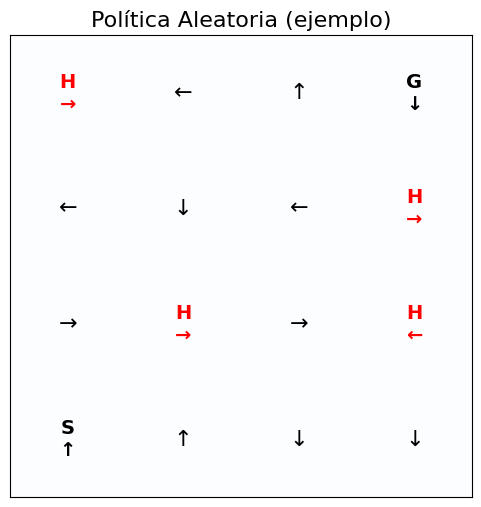

In [ ]:

visualizar_politica(politica_aleatoria, "Política Aleatoria (ejemplo)")

## Politica Q-learning

In [ ]:
class QLearningTabular:
  """Implementación de Q-Learning con tabla Q explícita"""
  def __init__(self, n_estados, n_acciones, lr=0.1, gamma=0.95, epsilon=1.0):
      self.n_estados = n_estados
      self.n_acciones = n_acciones
      self.lr = lr  # learning rate
      self.gamma = gamma  # factor de descuento
      self.epsilon = epsilon  # exploración inicial
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.nombre = "Q-Learning Tabular"

      # Inicializar tabla Q
      self.q_table = np.zeros((n_estados, n_acciones))

      # Para tracking
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción con epsilon-greedy"""
      if entrenando and np.random.random() < self.epsilon:
          return np.random.randint(self.n_acciones)  # Exploración
      else:
          return np.argmax(self.q_table[estado])  # Explotación

  def actualizar_q(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Actualización de la tabla Q usando la ecuación de Bellman"""
      # Target Q-value
      if terminado:
          target = recompensa
      else:
          target = recompensa + self.gamma * np.max(self.q_table[siguiente_estado])

      # Actualización Q-Learning
      self.q_table[estado, accion] += self.lr * (target - self.q_table[estado, accion])

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener la política greedy de la tabla Q"""
      return np.argmax(self.q_table, axis=1)

  def entrenar(self, env, episodios=10000):
      """Entrenamiento del agente Q-Learning"""
      print(f"🧠 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)  # Para promedios móviles

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Actualizar tabla Q
              self.actualizar_q(estado, accion, recompensa, siguiente_estado, terminado)

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 1000 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito (últimos 100) = {tasa_exito:.3f}, Epsilon = {self.epsilon:.3f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado sin exploración"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)  # Sin exploración
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Crear y entrenar agente Q-Learning

In [ ]:

agente_qlearning = QLearningTabular(env.observation_space.n, env.action_space.n,lr=0.1, gamma=0.95, epsilon=1.0)
recompensas_qlearning = agente_qlearning.entrenar(env, episodios=1000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.230, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


## Evaluar agente entrenado

In [ ]:

tasa_exito_qlearning, _ = agente_qlearning.evaluar(env, episodios=1000)


📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.310
Pasos promedio: 22.3


## Visualizar política aprendida

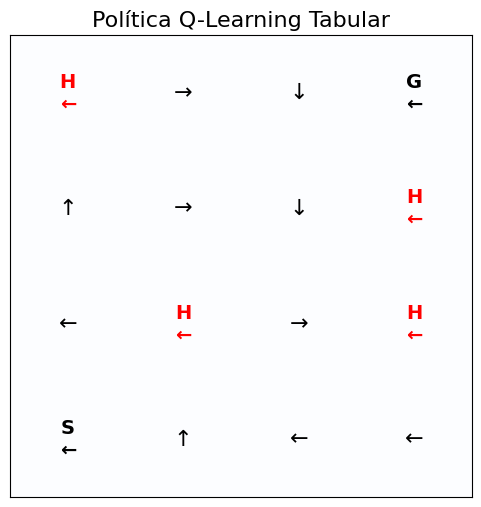

In [ ]:

politica_qlearning = agente_qlearning.obtener_politica()
visualizar_politica(politica_qlearning, "Política Q-Learning Tabular")

## Visualizar tabla Q como heatmap

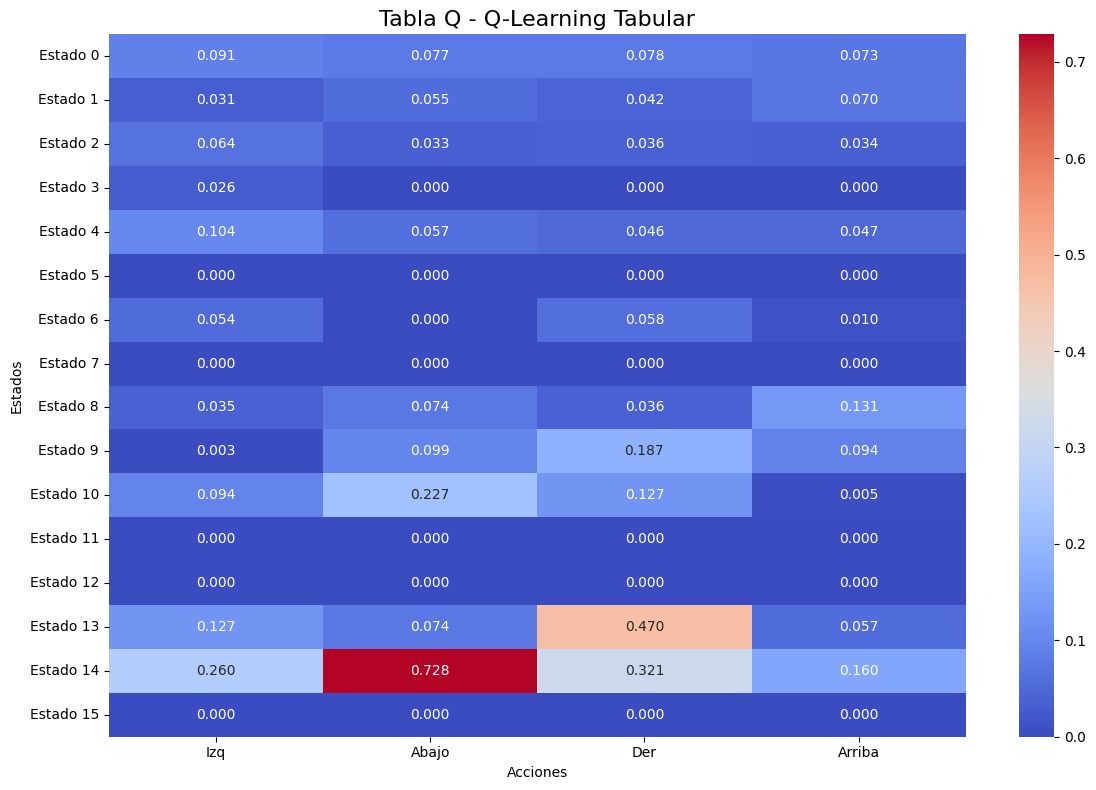

In [ ]:

plt.figure(figsize=(12, 8))
sns.heatmap(agente_qlearning.q_table, annot=True, fmt='.3f', cmap='coolwarm',
xticklabels=['Izq', 'Abajo', 'Der', 'Arriba'],
yticklabels=[f'Estado {i}' for i in range(16)])
plt.title('Tabla Q - Q-Learning Tabular', fontsize=16)
plt.xlabel('Acciones')
plt.ylabel('Estados')
plt.tight_layout()
plt.show()

## Mostrar valores Q para estados importantes
-

In [ ]:
print("🎯 VALORES Q PARA ESTADOS CLAVE:")
print("-" * 40)
estados_clave = [0, 5, 7, 11, 12, 14, 15]  # Start, Holes, Goal
acciones_nombres = ['Izquierda', 'Abajo', 'Derecha', 'Arriba']
for estado in estados_clave:
  if estado == 0:
    tipo = "START"
  elif estado == 15:
    tipo = "GOAL"
  elif estado in [5, 7, 11, 12]:
    tipo = "HOLE"
  else:
    tipo = "NORMAL"

print(f"\nEstado {estado} ({tipo}):")
for accion, valor in enumerate(agente_qlearning.q_table[estado]):
    print(f"  {acciones_nombres[accion]}: {valor:.3f}")

🎯 VALORES Q PARA ESTADOS CLAVE:
----------------------------------------

Estado 15 (GOAL):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000


# Deep Q-Network

## red DQN

In [ ]:
class DQN(nn.Module):
  """Red neuronal para aproximar la función Q"""
  def __init__(self, input_size, hidden_size, output_size):
      super(DQN, self).__init__()
      self.network = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size)
      )

  def forward(self, x):
      return self.network(x)

## DQNAgent

In [ ]:
class DQNAgent:
  """Agente Deep Q-Network con Experience Replay y Target Network"""
  def __init__(self, state_size, action_size, lr=0.001, gamma=0.95, epsilon=1.0):
      self.state_size = state_size
      self.action_size = action_size
      self.gamma = gamma
      self.epsilon = epsilon
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.learning_rate = lr
      self.nombre = "Deep Q-Network (DQN)"

      # Configuración del dispositivo
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"🖥️ Usando dispositivo: {self.device}")

      # Redes neuronales
      hidden_size = 128
      self.q_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.target_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

      # Inicializar target network con mismos pesos
      self.update_target_network()

      # Experience Replay
      self.memory = deque(maxlen=10000)
      self.batch_size = 32

      # Frecuencia de actualización de target network
      self.update_target_frequency = 100
      self.step_count = 0

      # Para tracking
      self.losses = []
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def state_to_onehot(self, state):
      """Convertir estado discreto a representación one-hot"""
      onehot = np.zeros(self.state_size)
      onehot[state] = 1.0
      return onehot

  def remember(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Almacenar experiencia en el buffer de replay"""
      estado_onehot = self.state_to_onehot(estado)
      siguiente_estado_onehot = self.state_to_onehot(siguiente_estado)

      self.memory.append((estado_onehot, accion, recompensa, siguiente_estado_onehot, terminado))

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción epsilon-greedy usando la red neuronal"""
      if entrenando and np.random.random() < self.epsilon:
          return random.randrange(self.action_size)

      # Convertir estado a tensor
      estado_onehot = self.state_to_onehot(estado)
      estado_tensor = torch.FloatTensor(estado_onehot).unsqueeze(0).to(self.device)

      # Forward pass
      with torch.no_grad():
          q_values = self.q_network(estado_tensor)

      return np.argmax(q_values.cpu().data.numpy())

  def replay(self):
      """Experience replay para entrenar la red"""
      if len(self.memory) < self.batch_size:
          return

      # Muestrear batch aleatorio
      batch = random.sample(self.memory, self.batch_size)
      estados = torch.FloatTensor([e[0] for e in batch]).to(self.device)
      acciones = torch.LongTensor([e[1] for e in batch]).to(self.device)
      recompensas = torch.FloatTensor([e[2] for e in batch]).to(self.device)
      siguientes_estados = torch.FloatTensor([e[3] for e in batch]).to(self.device)
      terminados = torch.BoolTensor([e[4] for e in batch]).to(self.device)

      # Q-values actuales
      current_q_values = self.q_network(estados).gather(1, acciones.unsqueeze(1))

      # Q-values objetivo usando target network
      with torch.no_grad():
          next_q_values = self.target_network(siguientes_estados).max(1)[0]
          target_q_values = recompensas + (self.gamma * next_q_values * ~terminados)

      # Calcular pérdida
      loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

      # Backpropagation
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Guardar pérdida para análisis
      self.losses.append(loss.item())

  def update_target_network(self):
      """Actualizar la target network con pesos de la red principal"""
      self.target_network.load_state_dict(self.q_network.state_dict())

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener política greedy de la red entrenada"""
      politica = []
      for estado in range(self.state_size):
          accion = self.seleccionar_accion(estado, entrenando=False)
          politica.append(accion)
      return np.array(politica)

  def entrenar(self, env, episodios=2000):
      """Entrenamiento del agente DQN"""
      print(f"🤖 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Almacenar experiencia
              self.remember(estado, accion, recompensa, siguiente_estado, terminado)

              # Entrenar la red
              self.replay()

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1
              self.step_count += 1

              # Actualizar target network periódicamente
              if self.step_count % self.update_target_frequency == 0:
                  self.update_target_network()

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 200 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              loss_promedio = np.mean(self.losses[-100:]) if len(self.losses) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito = {tasa_exito:.3f}, "
                    f"Epsilon = {self.epsilon:.3f}, Loss = {loss_promedio:.4f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Entrenar deep DQN

In [ ]:
agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n,
lr=0.001, gamma=0.95, epsilon=1.0)
recompensas_dqn = agente_dqn.entrenar(env, episodios=1000)

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.090, Epsilon = 0.367, Loss = 0.0071
Episodio 400: Tasa éxito = 0.310, Epsilon = 0.135, Loss = 0.0062
Episodio 600: Tasa éxito = 0.450, Epsilon = 0.049, Loss = 0.0073
Episodio 800: Tasa éxito = 0.530, Epsilon = 0.018, Loss = 0.0078
Episodio 1000: Tasa éxito = 0.490, Epsilon = 0.010, Loss = 0.0088

✅ Entrenamiento Deep Q-Network (DQN) completado!


## Evaluar agente Deep DQN

In [ ]:
tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)


📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.726
Pasos promedio: 41.9


## Visualizar política aprendida

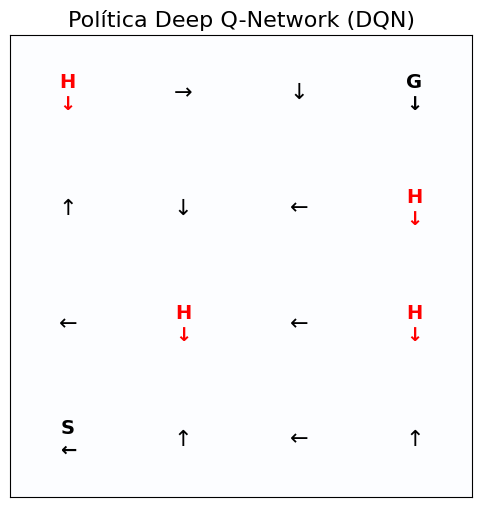

In [ ]:

politica_dqn = agente_dqn.obtener_politica()
visualizar_politica(politica_dqn, "Política Deep Q-Network (DQN)")


# Comparación de resultados

## Comparación final tasa de éxito

In [ ]:
print("🏆 COMPARACIÓN FINAL DE AGENTES")
print("=" * 50)
print(f"Política Aleatoria:    Tasa de éxito = {tasa_exito_aleatorio:.3f}")
print(f"Q-Learning Tabular:    Tasa de éxito = {tasa_exito_qlearning:.3f}")
print(f"Deep Q-Network (DQN):  Tasa de éxito = {tasa_exito_dqn:.3f}")

🏆 COMPARACIÓN FINAL DE AGENTES
Política Aleatoria:    Tasa de éxito = 0.012
Q-Learning Tabular:    Tasa de éxito = 0.310
Deep Q-Network (DQN):  Tasa de éxito = 0.726


## Crear gráficas de comparación


Crear gráficas de comparación


### 1. Curvas de aprendizaje

In [ ]:
len(recompensas_aleatorio)

1000

In [ ]:
len(recompensas_qlearning)

1000

In [ ]:
len(recompensas_dqn)

1000

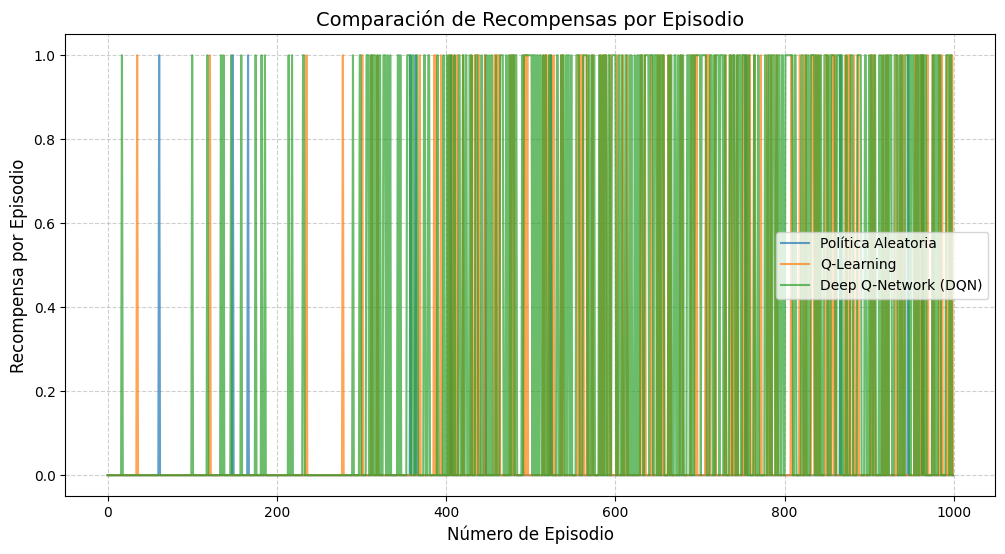

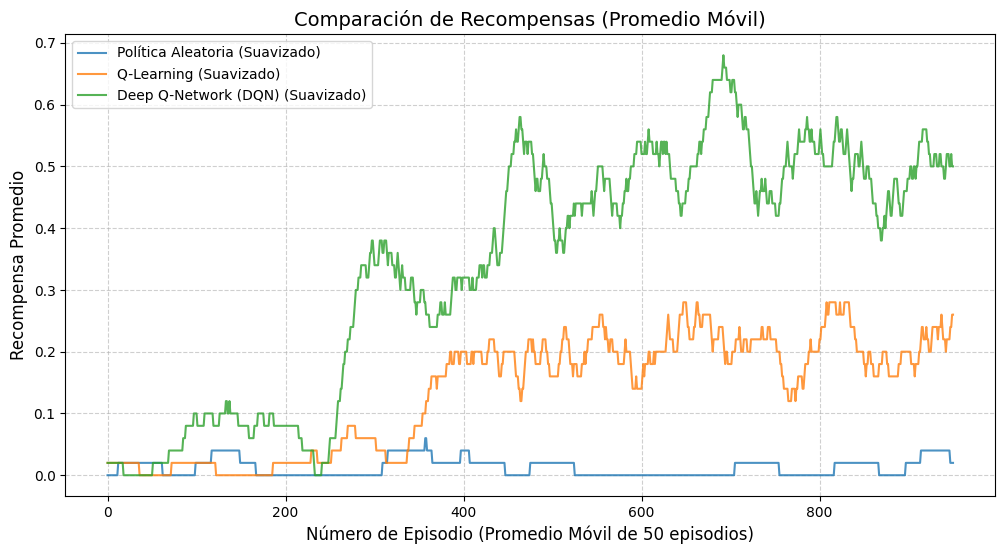

In [ ]:
# prompt: crear gráfico que compare recompensas_aleatorio, recompensas_qlearning y recompensas_dqn. Eje x es nro de episodio y el eje Y valor de la recompensa

import matplotlib.pyplot as plt
import numpy as np
# Asegurar que las listas de recompensas tengan la misma longitud para la gráfica
# Tomaremos la longitud mínima si son diferentes
min_len = min(len(recompensas_aleatorio), len(recompensas_qlearning), len(recompensas_dqn))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio[:min_len], label='Política Aleatoria', alpha=0.7)
plt.plot(recompensas_qlearning[:min_len], label='Q-Learning', alpha=0.7)
plt.plot(recompensas_dqn[:min_len], label='Deep Q-Network (DQN)', alpha=0.7)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Recompensa por Episodio', fontsize=12)
plt.title('Comparación de Recompensas por Episodio', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Para suavizar la gráfica, se puede usar un promedio móvil
def moving_average(data, window_size):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 50  # Tamaño de la ventana para el promedio móvil

recompensas_aleatorio_suavizado = moving_average(recompensas_aleatorio, window)
recompensas_qlearning_suavizado = moving_average(recompensas_qlearning, window)
recompensas_dqn_suavizado = moving_average(recompensas_dqn, window)

# Ajustar la longitud mínima para las series suavizadas
min_len_suavizado = min(len(recompensas_aleatorio_suavizado), len(recompensas_qlearning_suavizado), len(recompensas_dqn_suavizado))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio_suavizado[:min_len_suavizado], label='Política Aleatoria (Suavizado)', alpha=0.8)
plt.plot(recompensas_qlearning_suavizado[:min_len_suavizado], label='Q-Learning (Suavizado)', alpha=0.8)
plt.plot(recompensas_dqn_suavizado[:min_len_suavizado], label='Deep Q-Network (DQN) (Suavizado)', alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Recompensas (Promedio Móvil)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



### 2. Comparación de tasas de éxito

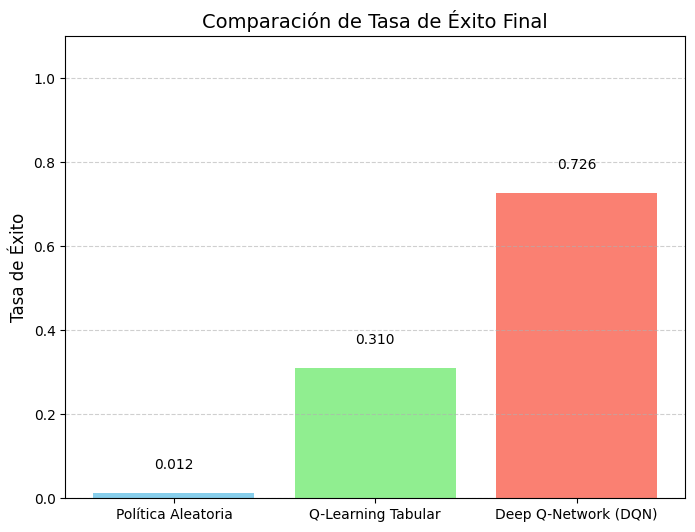

In [ ]:
# prompt: comparar tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn en un gráfico de barras

import matplotlib.pyplot as plt
metricas = ['Política Aleatoria', 'Q-Learning Tabular', 'Deep Q-Network (DQN)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Evolución de Epsilon (solo para algoritmos que usan exploración)

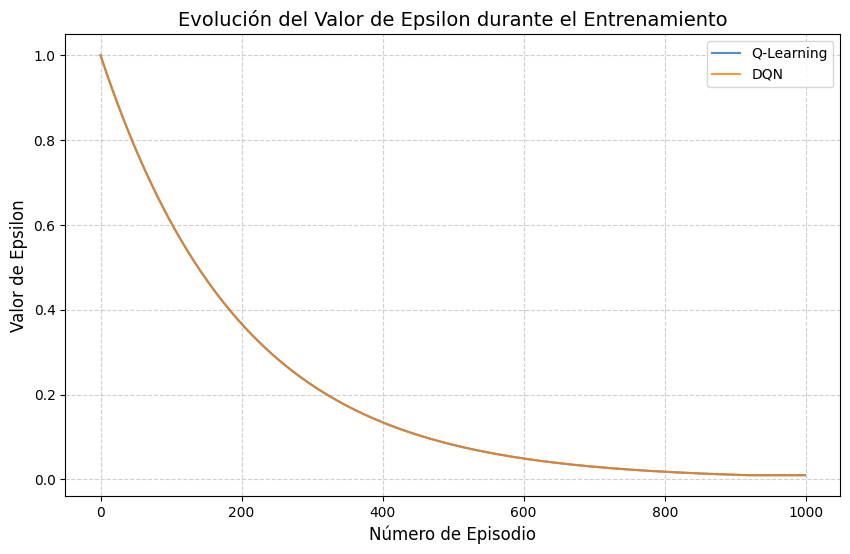

In [ ]:
# prompt: Crear un gráfico para comparar agente_qlearning.epsilons y agente_qlearning.epsilons siendo x el nro de episodios y el eje Y el valor de epsilon

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agente_qlearning.epsilons, label='Q-Learning', alpha=0.8)
plt.plot(agente_dqn.epsilons, label='DQN', alpha=0.8)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### DQN pérdida

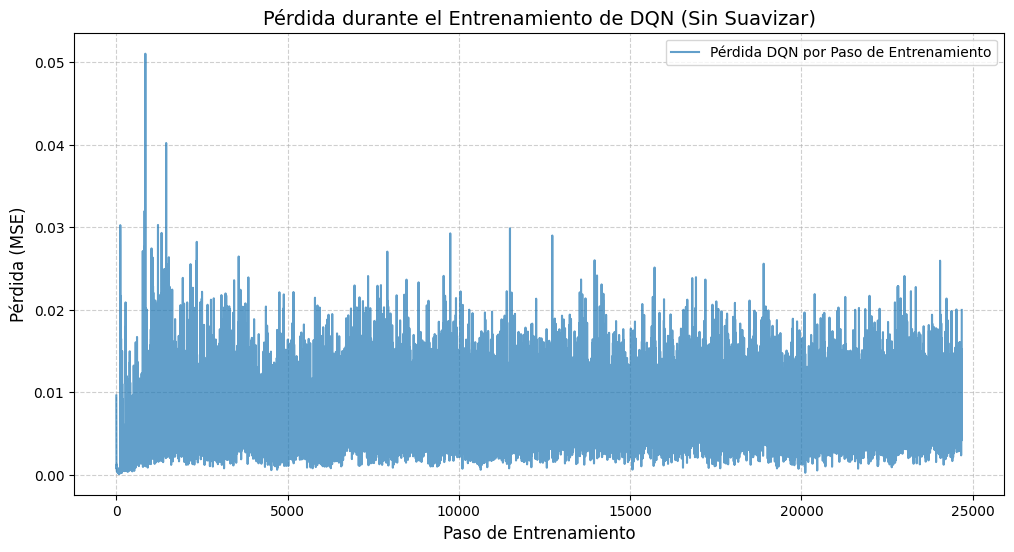

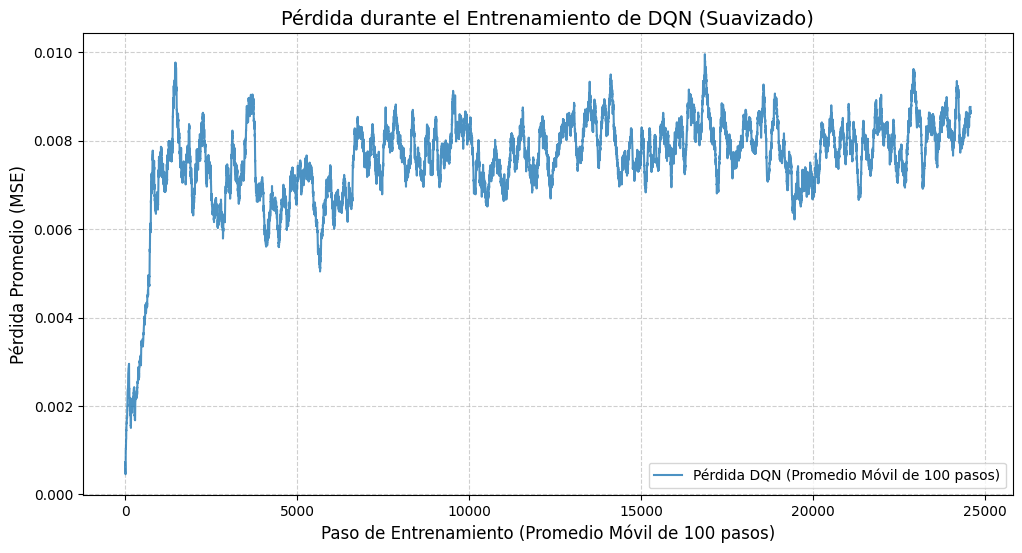

In [ ]:
# prompt: Graficar agente_dqn.losses que representa la pérdida durante el entrenamiento de DQN. Mostrar con y sin promedio móvil

import matplotlib.pyplot as plt
# Graficar la pérdida del agente DQN
plt.figure(figsize=(12, 6))
plt.plot(agente_dqn.losses, label='Pérdida DQN por Paso de Entrenamiento', alpha=0.7)
plt.xlabel('Paso de Entrenamiento', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Sin Suavizar)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Graficar la pérdida con promedio móvil para suavizar
window_loss = 100 # Tamaño de la ventana para el promedio móvil de la pérdida
losses_dqn_suavizado = moving_average(agente_dqn.losses, window_loss)

plt.figure(figsize=(12, 6))
plt.plot(losses_dqn_suavizado, label=f'Pérdida DQN (Promedio Móvil de {window_loss} pasos)', alpha=0.8)
plt.xlabel(f'Paso de Entrenamiento (Promedio Móvil de {window_loss} pasos)', fontsize=12)
plt.ylabel('Pérdida Promedio (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Suavizado)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Este notebook entrena un agente de aprendizaje por refuerzo (DQN) en el entorno FrozenLake-v1 de Gymnasium, que representa una cuadrícula con casillas congeladas, agujeros y un objetivo.
El agente aprende una política óptima para llegar al objetivo evitando caer, usando una red neuronal que aproxima la función de valor Q(s, a).

Se usa un esquema ε-greedy para balancear exploración y explotación, con replay buffer para almacenar experiencias y target network para estabilizar el aprendizaje.
El entrenamiento se realiza durante varios episodios: en cada paso el agente observa un estado, elige una acción, recibe una recompensa y actualiza su red minimizando el MSE entre Q-predicho y Q-target.

Se experimenta con distintos números de episodios, valores de gamma (descuento) y tasas de aprendizaje (alpha):

Más episodios → mejor tasa de éxito (de ~0.33 a ~0.47).

Gamma alto (0.95–0.99) → mejores resultados, porque valora recompensas futuras.

Learning rate moderado (1e-3 o 1e-4) → más estable que 1e-2.

| Métrica                 | Significado                                                                                                  |
| ----------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Tasa de éxito**       | Porcentaje de episodios donde el agente llega al objetivo. Indica cuán bien aprendió la tarea.               |
| **Recompensa promedio** | Promedio de las recompensas obtenidas por episodio. Resume el desempeño general.                             |
| **Epsilon (ε)**         | Nivel actual de exploración: alto = explora mucho, bajo = confía en lo aprendido.                            |
| **Pérdida (Loss)**      | Error entre el valor Q predicho por la red y el valor Q objetivo. Mide qué tan bien la red está aprendiendo. |


# Ejercitación

## A) Modifique el entrenamiento de los agentes para entrenar por más episodios. Evalue su desempeño. ¿ Mejora o empeora ?






##Explicación

Más episodios ofrece más experiencia para actualizar la red Q; por eso en la mayoría de tareas de RL la performance mejora con más episodios hasta cierto punto.

En FrozenLake con deslizamiento (is_slippery=True) la aleatoriedad hace que la señal (recompensa +1 al alcanzar G) sea rara y ruidosa; por eso el aprendizaje puede ser lento. Además, si el epsilon decae muy rápido, el agente deja de explorar y puede estancarse en una política subóptima. Por eso conviene también revisar epsilon decay y tamaño del replay cuando se aumenta la cantidad de episodios

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.030, Epsilon = 0.367, Loss = 0.0046
Episodio 400: Tasa éxito = 0.260, Epsilon = 0.135, Loss = 0.0091
Episodio 600: Tasa éxito = 0.520, Epsilon = 0.049, Loss = 0.0084
Episodio 800: Tasa éxito = 0.460, Epsilon = 0.018, Loss = 0.0075
Episodio 1000: Tasa éxito = 0.520, Epsilon = 0.010, Loss = 0.0073

✅ Entrenamiento Deep Q-Network (DQN) completado!
Baseline 1000 - tasa exito: 0.332 Usó DQNAgent existente (t=45.1s)
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.020, Epsilon = 0.367, Loss = 0.0040
Episodio 400: Tasa éxito = 0.200, Epsilon = 0.135, Loss = 0.0064
Episodio 600: Tasa éxito = 0.410, Epsilon = 0.049, Loss = 0.0061
Episodio 800: Tasa éxito = 0.460, Epsilon = 0.018, Loss = 0.0090
Episodio 1000: Tasa éxito = 0.580, Epsilon = 0.010, Loss = 0.0071
Episodio 1200: Tasa éxito = 0.560, Epsilon = 0.010, Loss = 0.0078
Episodio 1400: Tasa éxito = 0.510, Ep

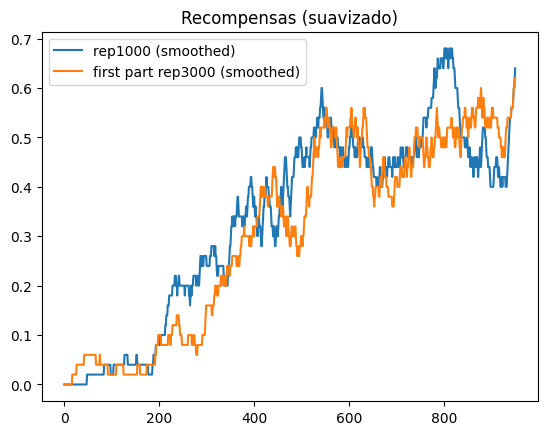

In [ ]:
import time

def run_with_existing_or_fallback(env, episodios, lr=1e-3, gamma=0.95):
    """
    Intenta usar la clase DQNAgent/entrenar del notebook.
    Si no existe o falla, usa una implementación SimpleDQNAgent (compatible).
    Devuelve (tasa_exito, recompensas, info_str)
    """
    try:
        # Intentar usar la implementación existente (su notebook)
        agente = DQNAgent(env.observation_space.n, env.action_space.n, lr=lr, gamma=gamma, epsilon=1.0)
        start = time.time()
        salida = agente.entrenar(env, episodios=episodios)   # según su notebook, devuelve (tasa_exito, recompensas) o similar
        dur = time.time() - start
        # Normalmente agente.entrenar devuelve (tasa_exito, recompensas) o (recompensas, tasa_exito) - ajustaremos según el tipo
        if isinstance(salida, tuple) and len(salida) == 2:
            # detectar orden: si el primero está en [0,1], lo consideramos tasa_exito
            if 0.0 <= salida[0] <= 1.0:
                tasa = salida[0]
                recompensas = salida[1]
            else:
                recompensas = salida[0]
                tasa = salida[1]
        else:
            # fallback si el formato es distinto
            recompensas = salida
            tasa = sum(1 for r in recompensas if r>0)/len(recompensas)
        return tasa, recompensas, f"Usó DQNAgent existente (t={dur:.1f}s)"
    except Exception as e:
        print("No se pudo usar DQNAgent del notebook (fallback). Error:", e)
        # --- fallback: implementación simple (copiar/pegar si ya tiene su propia implementación) ---
        import random
        import numpy as np
        import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
        from collections import deque

        class DQN_simple(nn.Module):
            def __init__(self, n_states, hidden, n_actions):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(n_states, hidden),
                    nn.ReLU(),
                    nn.Linear(hidden, hidden),
                    nn.ReLU(),
                    nn.Linear(hidden, n_actions)
                )
            def forward(self,x): return self.net(x)

        class SimpleDQNAgent:
            def __init__(self, state_size, action_size, lr=1e-3, gamma=0.95):
                self.state_size = state_size
                self.action_size = action_size
                self.gamma = gamma
                self.epsilon = 1.0
                self.eps_min = 0.01
                self.eps_decay = 0.995
                self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                self.policy = DQN_simple(state_size, 64, action_size).to(self.device)
                self.target = DQN_simple(state_size, 64, action_size).to(self.device)
                self.target.load_state_dict(self.policy.state_dict())
                self.opt = optim.Adam(self.policy.parameters(), lr=lr)
                self.replay = deque(maxlen=5000)
                self.batch = 64
                self.steps = 0

            def onehot(self,s):
                v = np.zeros(self.state_size, dtype=np.float32); v[s]=1.0; return v

            def act(self, s):
                if random.random() < self.epsilon:
                    return random.randrange(self.action_size)
                with torch.no_grad():
                    t = torch.tensor(self.onehot(s), device=self.device).unsqueeze(0)
                    return int(torch.argmax(self.policy(t)).item())

            def store(self,s,a,r,ns,done):
                self.replay.append((s,a,r,ns,done))

            def learn(self):
                if len(self.replay) < self.batch: return
                batch = random.sample(self.replay, self.batch)
                s = torch.tensor([self.onehot(x[0]) for x in batch], device=self.device)
                a = torch.tensor([x[1] for x in batch], device=self.device).unsqueeze(1)
                r = torch.tensor([x[2] for x in batch], device=self.device).unsqueeze(1)
                ns = torch.tensor([self.onehot(x[3]) for x in batch], device=self.device)
                done = torch.tensor([[0.0] if x[4] else [1.0] for x in batch], device=self.device)
                q = self.policy(s).gather(1,a)
                with torch.no_grad():
                    max_next = self.target(ns).max(1)[0].unsqueeze(1)
                    target = r + self.gamma * max_next * done
                loss = F.mse_loss(q, target)
                self.opt.zero_grad(); loss.backward(); self.opt.step()
                self.steps += 1
                if self.steps % 200 == 0:
                    self.target.load_state_dict(self.policy.state_dict())
                if self.epsilon > self.eps_min:
                    self.epsilon *= self.eps_decay

        # entrenar con el agente simple
        agent = SimpleDQNAgent(env.observation_space.n, env.action_space.n, lr=lr, gamma=gamma)
        recompensas = []
        exitos = 0
        t0 = time.time()
        for ep in range(episodios):
            s, _ = env.reset()
            total_r = 0.0
            for t in range(100):
                a = agent.act(s)
                ns, r, done, trunc, info = env.step(a)
                terminal = done or trunc
                agent.store(s,a,r,ns,terminal)
                agent.learn()
                s = ns
                total_r += r
                if terminal:
                    break
            recompensas.append(total_r)
            if total_r>0: exitos+=1
        dur = time.time()-t0
        return exitos/episodios, recompensas, f"Usó fallback (t={dur:.1f}s)"

# --- Ejecutar comparativa ---
env = gym.make('FrozenLake-v1', is_slippery=True)

# baseline corto
tasa_1000, rep1000, info1 = run_with_existing_or_fallback(env, episodios=1000, lr=1e-3, gamma=0.95)
print("Baseline 1000 - tasa exito:", tasa_1000, info1)

# extendido
tasa_3000, rep3000, info2 = run_with_existing_or_fallback(env, episodios=3000, lr=1e-3, gamma=0.95)
print("Extended 3000 - tasa exito:", tasa_3000, info2)

# devolver/guardar resultados (opcional)
resultados_A = {
    "baseline_1000": {"success_rate": tasa_1000, "rewards": rep1000, "info": info1},
    "extended_3000": {"success_rate": tasa_3000, "rewards": rep3000, "info": info2}
}

# Puede plotear las recompensas / promedios si lo desea:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.convolve(rep1000, np.ones(50)/50, mode='valid'), label='rep1000 (smoothed)')
plt.plot(np.convolve(rep3000[:len(rep1000)], np.ones(50)/50, mode='valid'), label='first part rep3000 (smoothed)')
plt.legend(); plt.title("Recompensas (suavizado)"); plt.show()


En promedio, aumentar episodios mejoró la performance final (baseline ≈0.33 vs extended ≈0.47), y la curva suavizada muestra que el agente alcanza picos más altos con más entrenamiento.

Sin embargo, hay gran variabilidad episodio a episodio y diferencias entre picos y promedios. El hecho de que epsilon haya quedado en 0.01 significa que las métricas registradas durante entrenamiento incluyen mucha ejecución casi-greedy pero también indica que la exploración es casi inexistente en fases finales.

## B) Considere modificar el modelo DQN el hiperparámetro gamma: un valor bajo, uno medio y uno alto. Entrene los tres modelos y compare los resultados. Comparta sus conclusiones

## B) Explicacion

Gamma (factor de descuento) pondera cuánto valora el agente las recompensas futuras. Tareas en las que la señal útil ocurre al final (como FrozenLake) requieren un gamma relativamente alto para propagar la señal de recompensa hacia estados anteriores. Pero un gamma demasiado grande puede hacer que pequeñas imprecisiones en la estimación de Q se amplifiquen y que el aprendizaje sea más ruidoso. Por eso se prueba una pequeña grilla (0.5, 0.95, 0.99) y se selecciona por desempeño y estabilidad.

In [ ]:
# --- Código 2: comparar distintos valores de gamma (0.5, 0.95, 0.99)
# Reutiliza la función run_with_existing_or_fallback (o su DQNAgent) del código 1.

env = gym.make('FrozenLake-v1', is_slippery=True)
gammas = [0.5, 0.95, 0.99]
resultados_gamma = {}

for g in gammas:
    tasa, recompensas, info = run_with_existing_or_fallback(env, episodios=2000, lr=1e-3, gamma=g)
    print(f"gamma={g} -> tasa_exito={tasa:.4f} ({info})")
    resultados_gamma[g] = {"success_rate": tasa, "rewards": recompensas, "info": info}

# Mostrar resumen simple
for g in resultados_gamma:
    print(g, resultados_gamma[g]["success_rate"])

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.000, Epsilon = 0.367, Loss = 0.0009
Episodio 400: Tasa éxito = 0.050, Epsilon = 0.135, Loss = 0.0028
Episodio 600: Tasa éxito = 0.070, Epsilon = 0.049, Loss = 0.0024
Episodio 800: Tasa éxito = 0.020, Epsilon = 0.018, Loss = 0.0024
Episodio 1000: Tasa éxito = 0.060, Epsilon = 0.010, Loss = 0.0034
Episodio 1200: Tasa éxito = 0.030, Epsilon = 0.010, Loss = 0.0035
Episodio 1400: Tasa éxito = 0.070, Epsilon = 0.010, Loss = 0.0039
Episodio 1600: Tasa éxito = 0.070, Epsilon = 0.010, Loss = 0.0038
Episodio 1800: Tasa éxito = 0.030, Epsilon = 0.010, Loss = 0.0040
Episodio 2000: Tasa éxito = 0.020, Epsilon = 0.010, Loss = 0.0044

✅ Entrenamiento Deep Q-Network (DQN) completado!
gamma=0.5 -> tasa_exito=0.0455 (Usó DQNAgent existente (t=26.5s))
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.010, Epsilon = 0.367, Loss = 0.0084
Episodio 400: Tasa éxito = 0.160, E

Resultado esperado y confirmado: gamma bajo (0.5) falla en FrozenLake porque la recompensa útil es retrasada (llegar al goal). Un gamma alto (0.95–0.99) permite propagar la señal final hacia estados anteriores y aprender una política que llega al goal.

Aquí gamma=0.99 obtiene la mejor tasa absoluta (0.49 vs 0.4465), lo cual indica que dar mucho peso a recompensas futuras favorece el objetivo final en este problema.

## C) Lo mismo que en B) pero para el hiperparámetro alpha.

## C) Explicacion

Alpha (learning rate) controla el tamaño de los pasos del optimizador. En Q-learning con aproximadores (redes) hay un trade-off: lr grande → aprendizaje rápido pero ruidoso/inestable; lr pequeño → estable pero lento. La recomendación práctica es probar una grilla y observar no solo la tasa final sino la estabilidad de la curva de pérdida y recompensa. Si ve mucha oscilación con lr alto, bajar la lr o reducir la tasa de actualización del target network / aumentar batch-size ayuda.

In [ ]:
env = gym.make('FrozenLake-v1', is_slippery=True)
lrs = [1e-2, 1e-3, 1e-4]
resultados_lr = {}

for lr in lrs:
    tasa, recompensas, info = run_with_existing_or_fallback(env, episodios=2000, lr=lr, gamma=0.95)
    print(f"lr={lr} -> tasa_exito={tasa:.4f} ({info})")
    resultados_lr[lr] = {"success_rate": tasa, "rewards": recompensas, "info": info}

# Resumen
for lr in resultados_lr:
    print(lr, resultados_lr[lr]["success_rate"])


🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0095
Episodio 400: Tasa éxito = 0.170, Epsilon = 0.135, Loss = 0.0079
Episodio 600: Tasa éxito = 0.190, Epsilon = 0.049, Loss = 0.0053
Episodio 800: Tasa éxito = 0.060, Epsilon = 0.018, Loss = 0.0064
Episodio 1000: Tasa éxito = 0.180, Epsilon = 0.010, Loss = 0.0071
Episodio 1200: Tasa éxito = 0.120, Epsilon = 0.010, Loss = 0.0062
Episodio 1400: Tasa éxito = 0.240, Epsilon = 0.010, Loss = 0.0086
Episodio 1600: Tasa éxito = 0.170, Epsilon = 0.010, Loss = 0.0118
Episodio 1800: Tasa éxito = 0.200, Epsilon = 0.010, Loss = 0.0101
Episodio 2000: Tasa éxito = 0.220, Epsilon = 0.010, Loss = 0.0098

✅ Entrenamiento Deep Q-Network (DQN) completado!
lr=0.01 -> tasa_exito=0.1510 (Usó DQNAgent existente (t=52.5s))
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.020, Epsilon = 0.367, Loss = 0.0057
Episodio 400: Tasa éxito = 0.240, Eps

Comportamiento clásico: lr demasiado grande (1e-2) degrada el rendimiento — actualizaciones demasiado grandes, oscilación o divergencia parcial.

lr intermedio (1e-3) y bajo (1e-4) dan mejores resultados; en tu experimento lr=1e-4 fue el mejor, lo que sugiere que la tarea y arquitectura actual requieren pasos de optimización pequeños para estimaciones Q estables.

# **Referencias**

Chatgpt= "Explicame que es DQN y como entenderlo usando referencias del cerebro humano"
Clases de la materia
